# Download the dataset
The code installs Roboflow, authenticates using an API key, and downloads the specified skin disease dataset (version 1) into the workspace for use in model development.

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="secret")
project = rf.workspace("nagesh-pwywk").project("skin-disease-spiyb")
version = project.version(1)
dataset = version.download("folder")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.4/80.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Skin-Disease-1 in folder:: 100%|██████████| 4559/4559 [00:00<00:00, 4724.98it/s]


# Create validation dataset
This code moves images from the training directory to the validation directory. For each class, it creates the corresponding validation directory if it doesn't exist, selects 50 random images, and transfers them from the training folder to the validation folder, balancing the dataset across the two directories.

In [ ]:
import os
import shutil
import random

# Define paths
train_dir = '/content/Skin-Disease-1/train'  # Path to training directory
valid_dir = '/content/Skin-Disease-1/valid'     # Path to valid directory

# Create class directories in the valid directory
for class_name in os.listdir(train_dir):
    class_train_dir = os.path.join(train_dir, class_name)
    class_valid_dir = os.path.join(valid_dir, class_name)

    # Check if the class directory in training exists
    if not os.path.isdir(class_train_dir):
        continue  # Skip if it is not a directory

    # Create the class directory in the valid directory if it doesn't exist
    if not os.path.exists(class_valid_dir):
        os.makedirs(class_valid_dir)

    # Get all image files in the current class directory
    images = [f for f in os.listdir(class_train_dir) if os.path.isfile(os.path.join(class_train_dir, f))]

    # Randomly select 50 images to remove
    if len(images) > 50:
        images_to_remove = random.sample(images, 50)
    else:
        images_to_remove = images  # If less than 50 images, take all

    # Move the selected images to the valid directory
    for image in images_to_remove:
        src_path = os.path.join(class_train_dir, image)
        dest_path = os.path.join(class_valid_dir, image)

        # Move the image
        shutil.move(src_path, dest_path)

    print(f'Moved {len(images_to_remove)} images from {class_name} to valid directory.')

Moved 50 images from Actinic keratosis to test directory.
Moved 50 images from Vascular lesion to test directory.
Moved 50 images from Benign keratosis to test directory.
Moved 50 images from Squamous carcinoma cell to test directory.
Moved 50 images from Dermatofibroma to test directory.
Moved 50 images from Atopic Dermatitis to test directory.
Moved 50 images from Candidiasis Ringworm Tinea to test directory.
Moved 50 images from Melanoma to test directory.
Moved 50 images from Melanocytic nevus to test directory.


# Data pre-processing and augmentation
This code sets up image data generators for training and validation. The training data generator applies real-time data augmentation techniques such as rotation, shifting, shearing, zooming, and horizontal flipping, while both the training and validation data are rescaled to normalize pixel values. The `flow_from_directory` method loads images from the specified directories and processes them into batches for model training and validation, with a target image size of 224x224 and categorical labels.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image data generator for training and validation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)

# Train and validation directories
train_dir = '/content/Skin-Disease-1/train'
val_dir = '/content/Skin-Disease-1/valid'

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Validation generator
valid_generator = valid_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 3633 images belonging to 9 classes.
Found 454 images belonging to 9 classes.


# Creating the model
This code constructs a deep learning model using the pre-trained **EfficientNetB0** architecture as the base. The base model is loaded without the top classification layer and is frozen to retain its learned weights from the ImageNet dataset. Custom layers are added on top, including a global average pooling layer, a dense layer with 512 units activated by LeakyReLU, batch normalization, and dropout for regularization. The final output layer uses softmax activation for multiclass classification with 9 classes. The model is compiled with the **RMSprop** optimizer and categorical crossentropy as the loss function, and a summary of the model architecture is printed for review.

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop

# Load the pre-trained EfficientNetB0 model without the top layer
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Add new layers on top of the pre-trained base model
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)  # Pooling to reduce dimensionality

# adding a dense layer
x = Dense(512)(x)  # 512 units
x = LeakyReLU(alpha=0.01)(x)  # activation function
x = BatchNormalization()(x) # batch normalization layer
x = Dropout(0.5)(x)  # dropout for regularization

# Final output layer
outputs = Dense(9, activation='softmax')(x)

# Define the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.01),
              loss='categorical_crossentropy',  # For multiclass classification
              metrics=['accuracy'])

# Print model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,712,108 (17.98 MB)

 Trainable params: 4,669,061 (17.81 MB)

 Non-trainable params: 43,047 (168.16 KB)

# Training the model
This code trains the model for 30 epochs using the training data generator and evaluates its performance on the validation data generator, with progress updates enabled for each epoch.

In [ ]:
# Train the model with frozen base layers
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    verbose=1
)


Epoch 1/30


Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


128/128 ━━━━━━━━━━━━━━━━━━━━ 111s 679ms/step - accuracy: 0.1082 - loss: 2.9956 - val_accuracy: 0.1123 - val_loss: 2.3742
Epoch 2/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 56s 405ms/step - accuracy: 0.1230 - loss: 2.5468 - val_accuracy: 0.1123 - val_loss: 2.2737
Epoch 3/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 55s 408ms/step - accuracy: 0.1080 - loss: 2.4495 - val_accuracy: 0.1123 - val_loss: 2.4880
Epoch 4/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 81s 410ms/step - accuracy: 0.1101 - loss: 2.3590 - val_accuracy: 0.1123 - val_loss: 2.3490
Epoch 5/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 55s 407ms/step - accuracy: 0.1223 - loss: 2.2821 - val_accuracy: 0.1123 - val_loss: 2.7364
Epoch 6/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 55s 403ms/step - accuracy: 0.1042 - loss: 2.2721 - val_accuracy: 0.1233 - val_loss: 2.2074
Epoch 7/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 55s 404ms/step - accuracy: 0.1301 - loss: 2.2429 - val_accuracy: 0.1233 - val_loss: 2.2453
Epoch 8/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 56s 416ms/step - accuracy: 0.1088 - loss: 2.2596 - va

# Fine tuning the model after unfreezing the layers of the base model
This code unfreezes the last 80% of layers in the base model, excluding BatchNormalization layers, to allow fine-tuning. The model is then recompiled with a lower learning rate of 1e-5 for better convergence. Finally, the model continues training for an additional 30 epochs using the training and validation data generators.

In [ ]:
# Calculate the number of layers to unfreeze
total_layers = len(base_model.layers)
layers_to_unfreeze = int(total_layers * 0.8)  # 80% of total layers

# Unfreeze the last 80% of layers, excluding BatchNormalization layers
for layer in base_model.layers[-layers_to_unfreeze:]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

# Compile the model again for fine-tuning
model.compile(optimizer=RMSprop(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training with fine-tuning
history_fine_tune = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=30
)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


128/128 ━━━━━━━━━━━━━━━━━━━━ 191s 907ms/step - accuracy: 0.1362 - loss: 3.6605 - val_accuracy: 0.0991 - val_loss: 519.3173
Epoch 2/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 96s 450ms/step - accuracy: 0.1534 - loss: 2.9884 - val_accuracy: 0.0859 - val_loss: 2063.4443
Epoch 3/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 61s 453ms/step - accuracy: 0.2036 - loss: 2.8098 - val_accuracy: 0.1189 - val_loss: 3.2437
Epoch 4/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 61s 454ms/step - accuracy: 0.2745 - loss: 2.6569 - val_accuracy: 0.1167 - val_loss: 481.9142
Epoch 5/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 60s 447ms/step - accuracy: 0.3135 - loss: 2.2727 - val_accuracy: 0.1079 - val_loss: 7.5559
Epoch 6/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 81s 446ms/step - accuracy: 0.3687 - loss: 2.1268 - val_accuracy: 0.1674 - val_loss: 447.4790
Epoch 7/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 83s 445ms/step - accuracy: 0.3636 - loss: 2.0474 - val_accuracy: 0.2885 - val_loss: 3.5363
Epoch 8/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 61s 454ms/step - accuracy: 0.3696 - loss: 1.

# F1 Score calculation and Confusion Matrix visualization
This code generates predictions on the validation set and calculates the **F1 score** to evaluate the model's performance, particularly accounting for class imbalance. The true labels are obtained from the validation generator, and the F1 score is computed using the macro-average method. Additionally, a **confusion matrix** is created to visualize the model's prediction results. The confusion matrix is then plotted using Seaborn for better readability, providing insights into the model's classification performance across different classes.

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
F1 Score (Macro): 0.8502883784318352


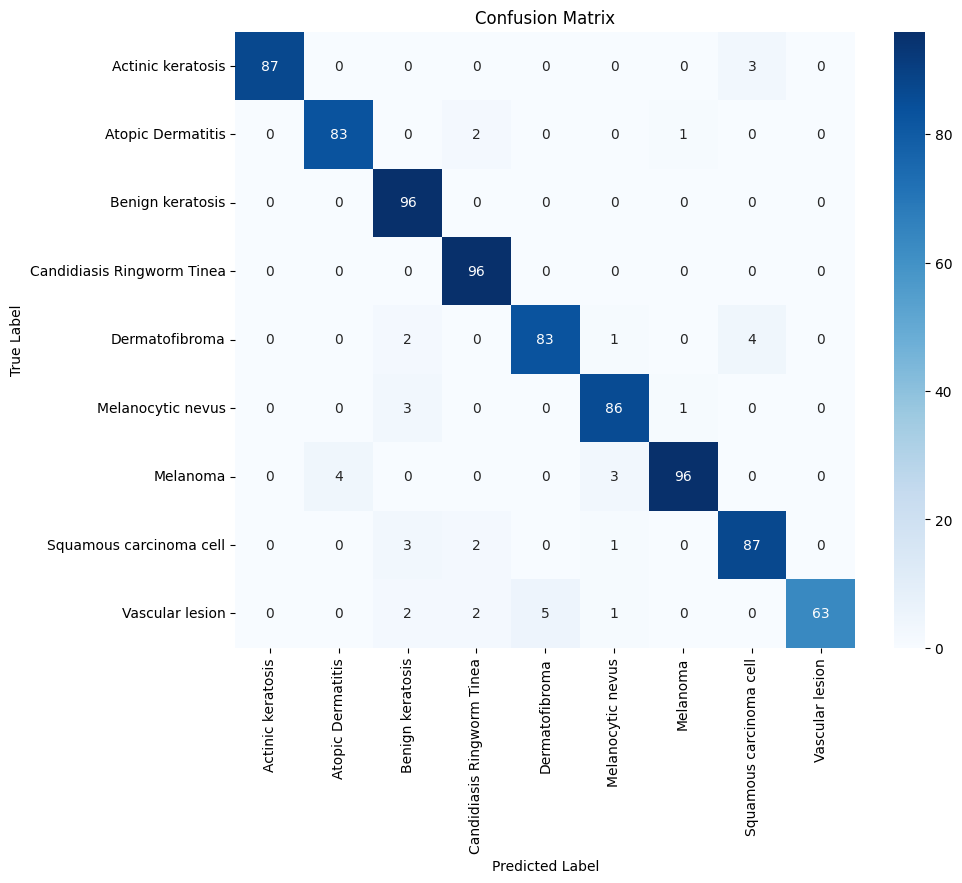

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
from tensorflow.keras.models import load_model

# Generate predictions on validation set
val_preds = model.predict(val_generator)
val_preds_classes = np.argmax(val_preds, axis=1)

# Get true labels from the validation set
val_true_classes = val_generator.classes

# Calculate F1 score (macro-average to account for class imbalance)
f1 = f1_score(val_true_classes, val_preds_classes, average='macro')
print(f"F1 Score (Macro): {f1}")

# Calculate the confusion matrix
conf_matrix = confusion_matrix(val_true_classes, val_preds_classes)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))  # Adjust size for better readability
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=val_generator.class_indices, yticklabels=val_generator.class_indices)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Training and validation accuracy and loss over epochs
This code defines a function to plot training and validation metrics over epochs. It creates a 2x2 subplot layout displaying:

1. **Training Accuracy**: Shows the model's accuracy on the training dataset.
2. **Validation Accuracy**: Displays the model's accuracy on the validation dataset.
3. **Training Loss**: Illustrates the loss value during training.
4. **Validation Loss**: Depicts the loss value during validation.

Each plot is labeled and color-coded for clarity. The layout is adjusted to prevent overlap, and the function is called to visualize the metrics from the training history after fine-tuning.

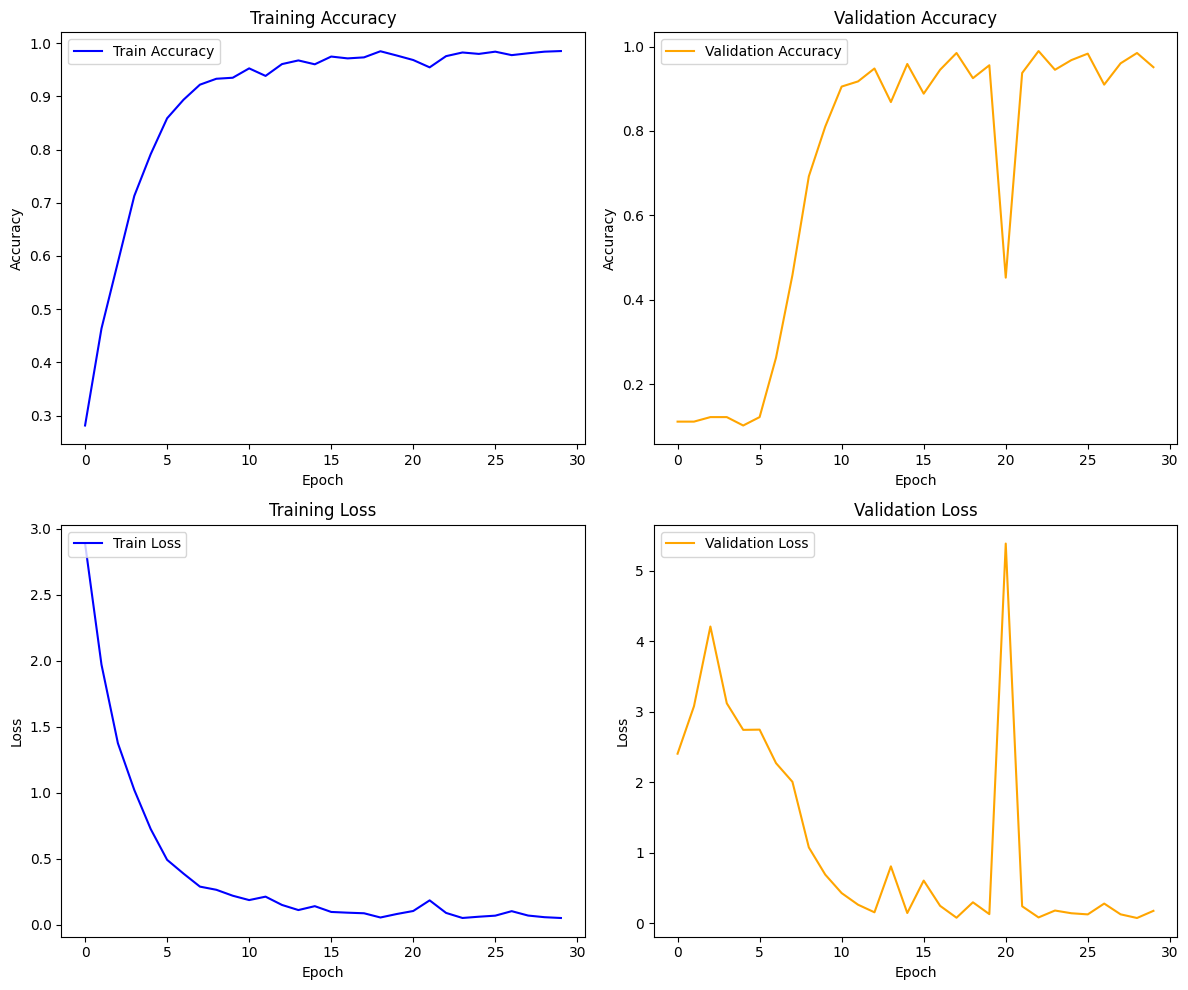

In [ ]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.figure(figsize=(12, 10))

    # Plot training accuracy
    plt.subplot(2, 2, 1)
    plt.plot(hist.history["accuracy"], label="Train Accuracy", color='blue')  # Blue for training
    plt.title("Training Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(loc="upper left")

    # Plot validation accuracy
    plt.subplot(2, 2, 2)
    plt.plot(hist.history["val_accuracy"], label="Validation Accuracy", color='orange')  # Orange for validation
    plt.title("Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(loc="upper left")

    # Plot training loss
    plt.subplot(2, 2, 3)
    plt.plot(hist.history["loss"], label="Train Loss", color='blue')
    plt.title("Training Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(loc="upper left")

    # Plot validation loss
    plt.subplot(2, 2, 4)
    plt.plot(hist.history["val_loss"], label="Validation Loss", color='orange')
    plt.title("Validation Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(loc="upper left")

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Call the function to plot all metrics
plot_hist(history_fine_tune)


# Top-k Accuracy
This code calculates **Top-k Accuracy** and **Top-1 Accuracy** for the model's predictions on the validation set.

1. **Top-k Accuracy**: The code defines a variable \( k \) (set to 5) and generates predictions using the validation generator. It retrieves the true class labels and identifies the top \( k \) predicted classes for each sample. The accuracy is computed by checking how many times the true label is among the top \( k \) predictions.

2. **Top-1 Accuracy**: This measures how often the model's most confident prediction (the top class) matches the true label. It calculates the percentage of correct predictions for the validation set.

The results for both metrics are printed, providing insights into the model's performance in multi-class classification tasks.

In [ ]:
import numpy as np

# Define the value of 'k' for top-k accuracy
k = 5

# Generate predictions on the validation set
val_preds = model.predict(val_generator)

# Get true labels from the validation set
val_true_classes = val_generator.classes

# Get the top k predicted classes for each sample
top_k_preds = np.argsort(val_preds, axis=1)[:, -k:]  # Sort and get the top k indices

# Calculate top-k accuracy
top_k_correct = 0
for i, true_label in enumerate(val_true_classes):
    if true_label in top_k_preds[i]:
        top_k_correct += 1

top_k_accuracy = top_k_correct / len(val_true_classes)
print(f"Top-{k} Accuracy: {top_k_accuracy * 100:.2f}%")

# For comparison: regular accuracy (top-1 accuracy)
val_preds_classes = np.argmax(val_preds, axis=1)
regular_accuracy = np.mean(val_preds_classes == val_true_classes)
print(f"Top-1 Accuracy: {regular_accuracy * 100:.2f}%")


26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 380ms/step
Top-5 Accuracy: 86.88%
Top-1 Accuracy: 84.29%


# Saving the model

In [ ]:
# Save the trained model
model.save('model/ENB0.h5')

# Model test accuracy

This code evaluates the final trained model on the test dataset. It loads the saved model, preprocesses the test images, and calculates the test accuracy to assess the model's performance on unseen data.

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the saved model
model = load_model('/model/ENB0.h5')

# Set up ImageDataGenerator for the test set
test_datagen = ImageDataGenerator(rescale=1./255)  # Normalizing test images

# Test directory
test_dir = '/content/Skin-Disease-1/test'

# Load test dataset with the generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # 'categorical' for multiclass
    shuffle=False  # Shuffle should be False for evaluation
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Found 454 images belonging to 9 classes.
Test Accuracy: 79.58%


# Make predictions
This code snippet loads a previously saved model and uses it to make predictions on a new image.

1. **Model Loading**: The Keras model is loaded from a specified file path, enabling further predictions without the need to retrain.

2. **Image Preprocessing**: A function is defined to load and preprocess the input image. This includes resizing the image to \(224 * 224\) pixels, normalizing pixel values to the range [0, 1], and adding a batch dimension to the array.

3. **Prediction**: The preprocessed image is passed to the model for prediction. The class with the highest predicted probability is determined.

4. **Class Mapping**: A list of class names corresponding to the output of the model is defined. The predicted class index is used to retrieve the respective class name.

5. **Output**: The predicted class name is printed, providing insight into the model's classification result for the input image.

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the saved model
model = load_model('/content/model/ENB0.h5')

# Load and preprocess the image for prediction
def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Path to the image you want to predict
image_path = '/content/Screenshot 2024-10-05 214431.png'
processed_image = load_and_preprocess_image(image_path)

# Make a prediction
predictions = model.predict(processed_image)

# Get the class with the highest probability
predicted_class_index = np.argmax(predictions, axis=1)[0]

# Define the class names
class_names = ['Actinic keratosis', 'Atopic Dermatitis', 'Benign keratosis',
               'Candidiasis Ringworm Tinea', 'Dermatofibroma', 'Melanocytic nevus',
               'Melanoma', 'Squamous carcinoma cell', 'Vascular lesion']

# Get the predicted class name
predicted_class_name = class_names[predicted_class_index]

print(f'Predicted class name: {predicted_class_name}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class name: Vascular lesion
